In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [439]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv").set_index("id")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [440]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We will do an outlier analysis first
Looking at the columns, we can expect outliers in the:
* age column (very low and very high age)
* hypertension (most people don't have it)
* heart disease (most people don't have it)
* avg glucose level (some people have abnormally high/low values)
* bmi (a bmi of 10 is abnormally low, similarly a bmi of 97 is hardly believable)

In [441]:
df[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]].describe()

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


We will have to examine these categorical variables separately

# Missing values

<Axes: ylabel='id'>

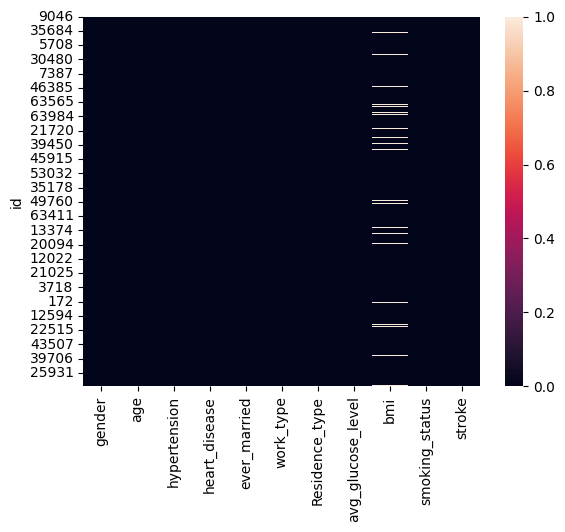

In [442]:
sns.heatmap(
    df.isna()
)

In [443]:
df.isna().sum().sort_values(ascending=False)

bmi                  201
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64

We have a few missing values of bmi.

Let's see if they are missing-at-random or missing-not-at-random

In [444]:
df.loc[~df["bmi"].isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [445]:
df.loc[df["bmi"].isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


It seems like respondents with missing bmi have different characteristics than the main group.

We should probably try to impute bmi values using a predictor.

In [446]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = df.loc[~df["bmi"].isna()].reset_index(drop=True).copy()
X["gender"] = X["gender"].apply(lambda x: x=="Male")
X["ever_married"] = X["ever_married"].apply(lambda x: x=="Yes")
X["smoking_status"] = X["smoking_status"].map({"never smoked": 0, "formerly smoked": 1, "smokes": 2, "Unknown": 0})
X = pd.get_dummies(
    data=X, columns=["work_type", "Residence_type"]
)
y = X.pop("bmi")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [447]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

train_rmse_list = []
test_rmse_list = []
search_space = [5, 10, 20, 30, 50, 75, 100]

for n_neighbors in search_space:
    print(
        "N-neighbors is set to:", n_neighbors, "neighbors"
    )
    reg = KNeighborsRegressor(
        n_neighbors=n_neighbors
    )
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    train_pred = reg.predict(X_train)
    train_rmse = round(
            np.sqrt(
                mean_squared_error(y_train, train_pred)
            ), 2
        )
    print(
        "train RMSE is:", train_rmse
    )
    test_rmse = round(
            np.sqrt(
                mean_squared_error(y_test, pred)
            ), 2
        )
    print(
        "test RMSE is:", test_rmse
    )
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

N-neighbors is set to: 5 neighbors
train RMSE is: 5.94
test RMSE is: 7.44
N-neighbors is set to: 10 neighbors
train RMSE is: 6.27
test RMSE is: 7.19
N-neighbors is set to: 20 neighbors
train RMSE is: 6.46
test RMSE is: 7.02
N-neighbors is set to: 30 neighbors


train RMSE is: 6.51
test RMSE is: 6.98
N-neighbors is set to: 50 neighbors
train RMSE is: 6.6
test RMSE is: 6.97
N-neighbors is set to: 75 neighbors
train RMSE is: 6.66
test RMSE is: 6.97
N-neighbors is set to: 100 neighbors
train RMSE is: 6.68
test RMSE is: 6.98


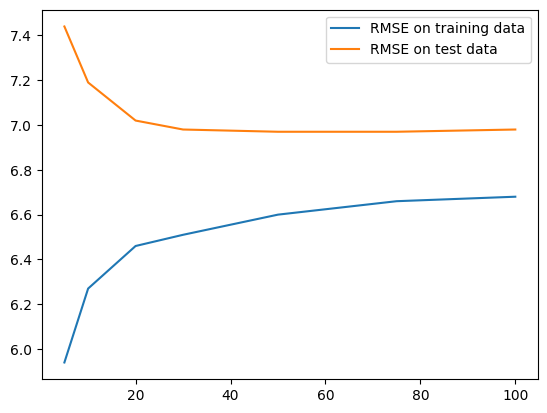

In [448]:
plt.plot(
    search_space,
    train_rmse_list,
    label="RMSE on training data"
)
plt.plot(
    search_space,
    test_rmse_list,
    label="RMSE on test data"
)
plt.legend()
plt.show()

It seems that the best option is to stop at around 30 neighbors.

Let's refit it and see the R^2.

In [449]:
reg = KNeighborsRegressor(
        n_neighbors=30
    )
reg.fit(X, y)
pred = reg.predict(X)
print(
    "R^2 is:", round(
        r2_score(y, pred), 3
        )
)

R^2 is: 0.299


In [450]:
print(
    "MSE of our model is:", round(
        mean_squared_error(y, pred), 3
        )
)
print(
    "MSE of mean imputation is:", round(
        mean_squared_error(y, [y.mean()]*len(y)), 3
        )
)

MSE of our model is: 43.228
MSE of mean imputation is: 61.674


Our model is slightly better than guessing. I guess we'll have to take it.

In [451]:
df_copy = df.reset_index(drop=True).copy()
df_copy["gender"] = df_copy["gender"].apply(lambda x: x=="Male")
df_copy["ever_married"] = df_copy["ever_married"].apply(lambda x: x=="Yes")
df_copy["smoking_status"] = df_copy["smoking_status"].map({"never smoked": 0, "formerly smoked": 1, "smokes": 2, "Unknown": 0})
df_copy = pd.get_dummies(
    data=df_copy, columns=["work_type", "Residence_type"]
)

for index, row in df_copy.iterrows():
    if pd.isna(row["bmi"]) or (row["bmi"]==0):
        df_copy.at[index, "bmi"] = reg.predict(
            df_copy.iloc[index,].to_frame().T.drop(columns="bmi")
        )

In [452]:
df["bmi"] = list(df_copy["bmi"].copy())
print("Missing values for bmi after imputation:", df["bmi"].isna().sum())

Missing values for bmi after imputation: 0


# Outliers

<Axes: xlabel='Count', ylabel='gender'>

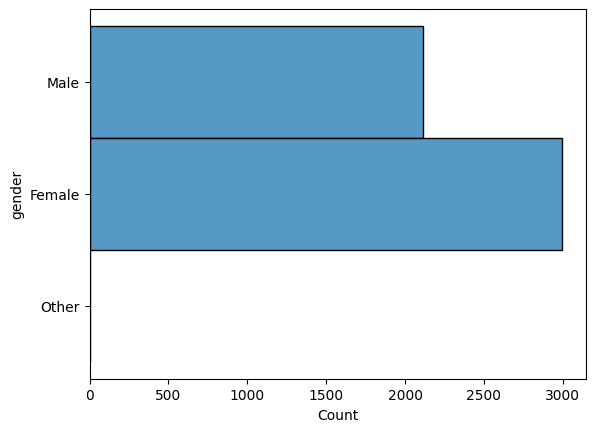

In [453]:
sns.histplot(
    y="gender",
    data=df
)

There are almost 1000 more female participants than males. We have to keep this in mind and possibly over/undersample

Also, there are very few participants with gender other. To prevent overfitting, we should drop these

In [454]:
print("Size before dropping")
print(df.value_counts("gender"))
df = df[df["gender"]!="Other"].copy()
print("Size after dropping")
print(df.value_counts("gender"))

Size before dropping
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Size after dropping
gender
Female    2994
Male      2115
Name: count, dtype: int64


<Axes: xlabel='age', ylabel='Count'>

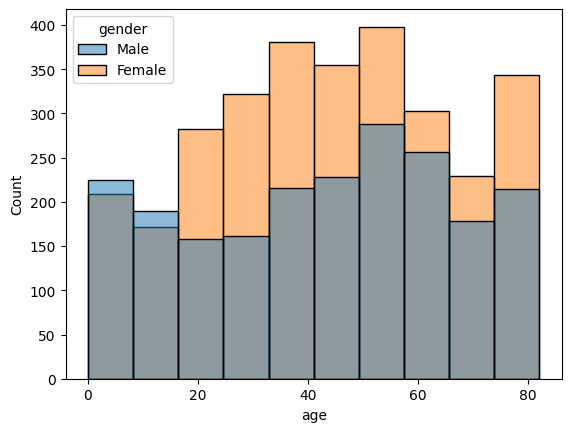

In [455]:
sns.histplot(
    data=df,
    x="age",
    hue="gender",
    bins=int(
        np.sqrt(
            len(df["age"].unique())
            )
    )
)

We can see that the two genders in this dataset have slightly different distributions.

We should keep that in mind when creating a model.

Also, there appear to be a lot of respondents in the highest age bin.

This could be because older participants are automatically put into the 80 year age bin.

In [456]:
df["hypertension"].value_counts()

hypertension
0    4611
1     498
Name: count, dtype: int64

<Axes: xlabel='hypertension', ylabel='age'>

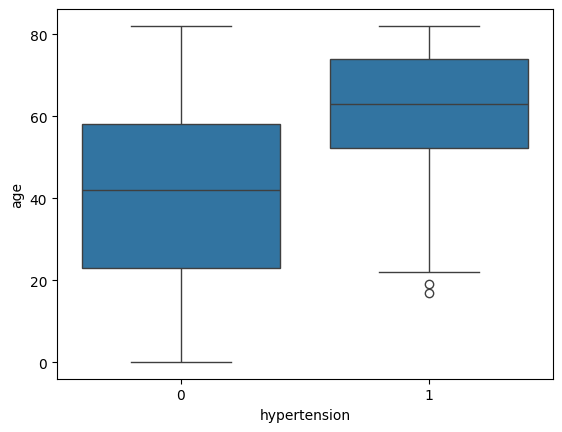

In [457]:
sns.boxplot(
    x="hypertension",
    y="age",
    data=df
)

Only some of the participants have hypertension.

It is also probably correlated with a higher age (participants below 20 years old are unlikely to have it).

Let's remove those outlying points.

In [458]:
df.loc[(df["age"]<20) & (df["hypertension"]==1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
62126,Female,19.0,1,0,No,Private,Rural,65.96,29.0,never smoked,0


In [459]:
df = df.loc[~(
    (df["age"]<20) & (df["hypertension"]==1)
    )].copy()

<Axes: xlabel='heart_disease', ylabel='age'>

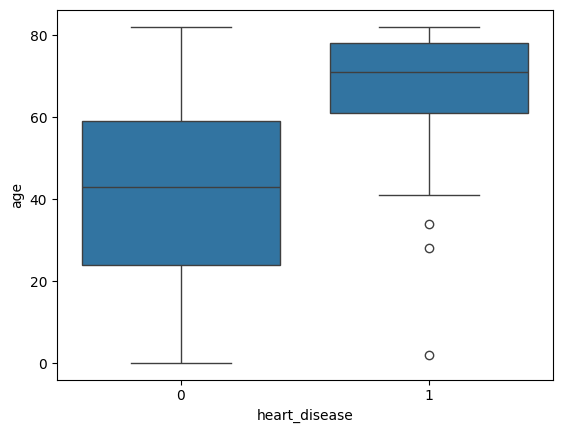

In [460]:
sns.boxplot(
    x="heart_disease",
    y="age",
    data=df
)

Heart disease is also highly correlated with age, though we see a few outliers where young people have it as well.

We should pay attention to these samples and take appropriate care.

<Axes: xlabel='gender', ylabel='ever_married'>

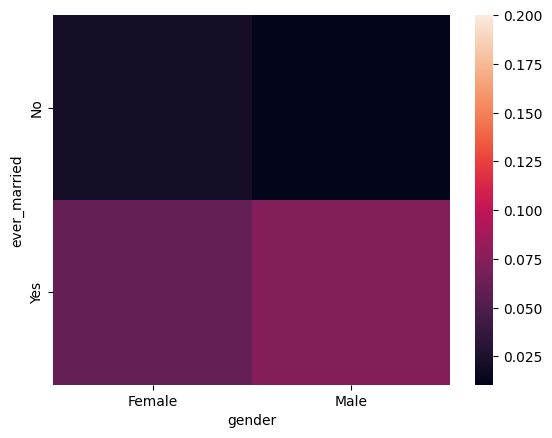

In [461]:
sns.heatmap(
    df.pivot_table(
        values="stroke",
        index="ever_married",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.2
)

Married people are more likely to have a stroke, though this could be just correlated with age.

<Axes: xlabel='ever_married', ylabel='age'>

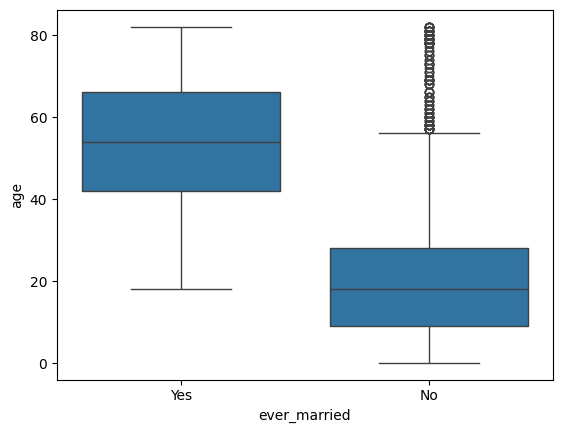

In [462]:
sns.boxplot(
    x="ever_married",
    y="age",
    data=df
)

This does seem to be the case.

In [463]:
df.loc[(df["age"]<40) & (df["heart_disease"]==1)].sort_values(by="age")

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
65688,Male,2.0,0,1,No,children,Urban,62.89,29.400000,Unknown,0
70693,Female,28.0,0,1,Yes,Private,Rural,111.27,19.100000,smokes,0
31091,Male,34.0,0,1,Yes,Private,Urban,106.23,29.546667,formerly smoked,0


In [464]:
df = df.loc[~(
    (df["age"]<40) & (df["heart_disease"]==1)
    )].copy()

In [465]:
df["work_type"].value_counts()

work_type
Private          2920
Self-employed     819
children          686
Govt_job          657
Never_worked       22
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='work_type'>

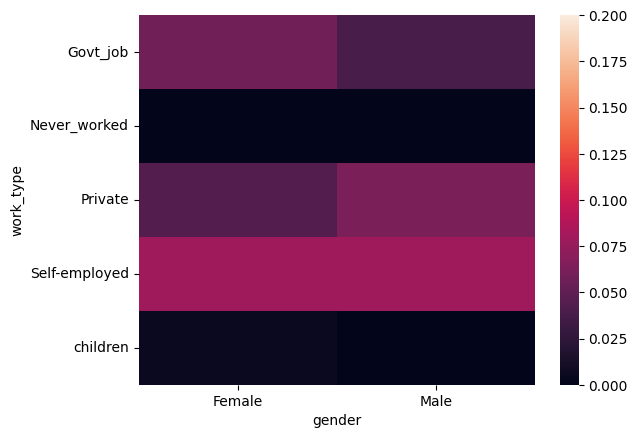

In [466]:
sns.heatmap(
    df.pivot_table(
        values="stroke",
        index="work_type",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.2
)

We can see that self-employed people have a slightly larger chance of stroke (for both genders).

Those who are caring for children (or never worked, though that is just a small sample) are very unlikely to have a stroke.

Let's drop those who never worked from the dataset.

In [467]:
df = df.loc[df["work_type"]!="Never_worked"].copy()

In [468]:
df["Residence_type"].value_counts()

Residence_type
Urban    2579
Rural    2503
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='Residence_type'>

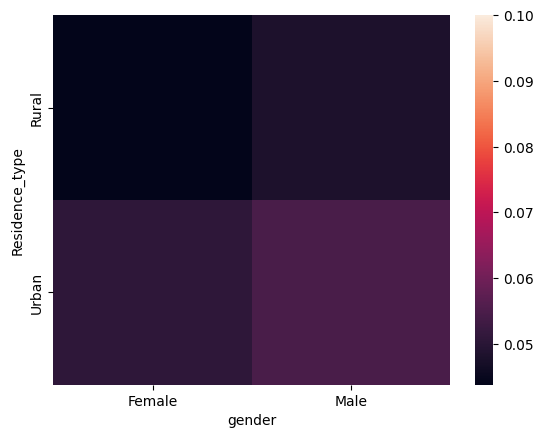

In [469]:
sns.heatmap(
    df.pivot_table(
        values="stroke",
        index="Residence_type",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.1
)

We can see that males in urban areas have a slightly higher chance of stroke, but it's hardly a significant difference.

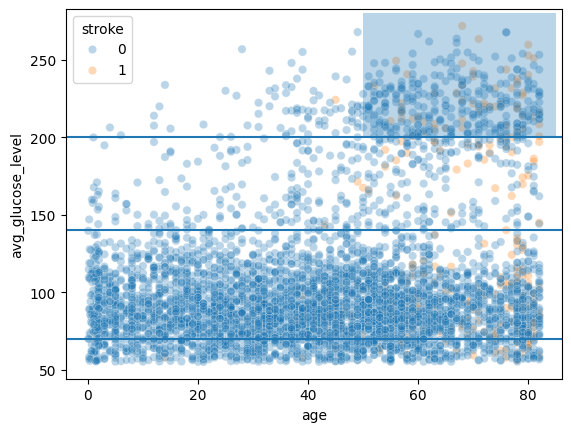

In [470]:
graph = sns.scatterplot(
    x="age",
    y="avg_glucose_level",
    hue="stroke",
    data=df,
    alpha=0.3
)
graph.axhline(70)
graph.axhline(140)
graph.axhline(200)
graph.add_patch(
    plt.Rectangle(
        (50, 200), 35, 80,
        alpha=0.3
        )
    )
plt.show()

ChatGPT told me, that the unit used is milligrams per deciliter (mg/Dl).

Values below 70 can indicate hypoglycemia for all ages (this can be caused by excessive insulin, prolonged fasting or rare tumors).

Normal values are between 70 and 100 (up to 140 if measured after eating).

Prediabetic levels are between 100 and 125 (up to 140-199 if measured after eating).

Diabetes are above 125 when fasting (higher than 200 after eating).


In [471]:
df["glucose_level_diagnosis"] = df["avg_glucose_level"].apply(
    lambda x: "hypoglycemia" if x<70
    else "non-diabetic" if x<140
    else "pre-diabetic" if x<200
    else "diabetic"
)

In [472]:
df["age_bin"] = df["age"].apply(lambda x: 0 if x<10 else int(str(x)[0]+"0"))

<Axes: xlabel='age_bin', ylabel='glucose_level_diagnosis'>

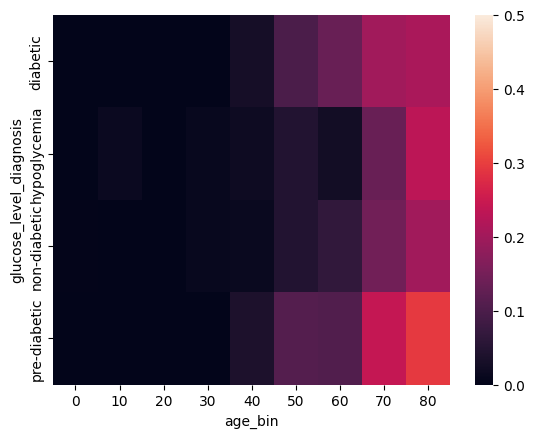

In [473]:
sns.heatmap(
    df.pivot_table(
        values="stroke",
        index="glucose_level_diagnosis",
        columns="age_bin",
        aggfunc="mean"
    ),
    vmax=0.5
)

We can see that the likelyhood of stroke increases with age, and also increased average glucose levels.

<Axes: xlabel='age', ylabel='bmi'>

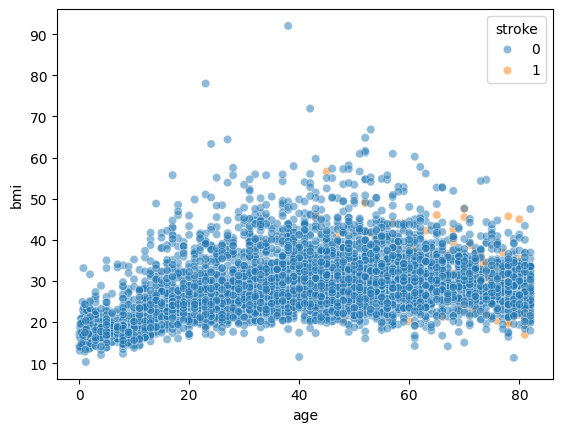

In [474]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="stroke",
    data=df,
    alpha=0.5
)

We can see that bmi is somewhat lower in children. We can also see a few outliers in bmi:

Those above 40 bmi are slightly unusual.

Those above 60 bmi are very rare.

Similarly, those under 10 bmi in children and 20 bmi in adults are unusual.

In [475]:
df_copy = df.copy()
avg_bmi_by_age_bin = df_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()
q001_bmi_by_age_bin = df_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.01)).to_dict()
q099_bmi_by_age_bin = df_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.99)).to_dict()

/tmp/ipykernel_6857/2354294742.py:2: FutureWarning: The provided callable <function mean at 0x7f535c5e0dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_bmi_by_age_bin = df_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()


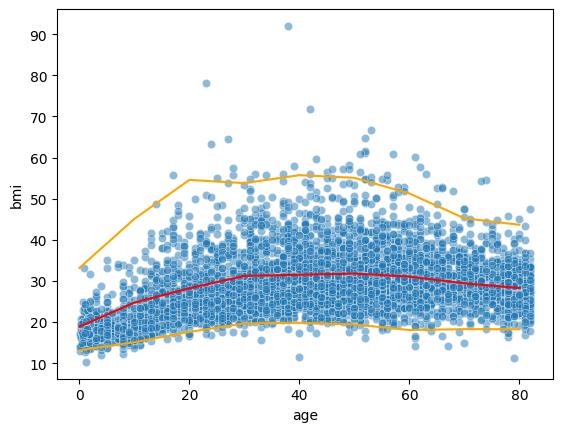

In [476]:
sns.scatterplot(
    x="age",
    y="bmi",
    # hue="stroke",
    data=df_copy,
    alpha=0.5
)
plt.plot(
    avg_bmi_by_age_bin.keys(), avg_bmi_by_age_bin.values(), color="red"
)
plt.plot(
    q001_bmi_by_age_bin.keys(), q001_bmi_by_age_bin.values(), color="orange"
)
plt.plot(
    q099_bmi_by_age_bin.keys(), q099_bmi_by_age_bin.values(), color="orange"
)
plt.show()

Hmm this doesn't isolate outliers very well, let's try a different method.

In [477]:
from sklearn.cluster import DBSCAN

X = df[["age", "bmi"]].copy()

clustering = DBSCAN(eps=4, min_samples=40) # EPS=5, MS=100
pred = clustering.fit_predict(X)

X["outlier"] = pred

<Axes: xlabel='age', ylabel='bmi'>

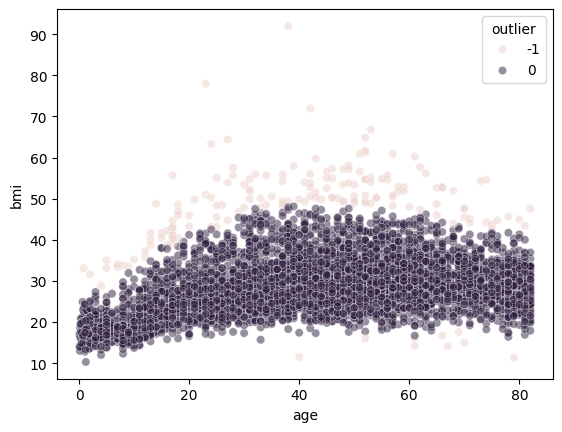

In [478]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="outlier",
    data=X,
    alpha=0.5
)

In [479]:
X["outlier"].value_counts()

outlier
 0    4917
-1     165
Name: count, dtype: int64

In [480]:
df = df.loc[X["outlier"]!=-1].copy()

In [481]:
df["smoking_status"].value_counts()

smoking_status
never smoked       1806
Unknown            1486
formerly smoked     854
smokes              771
Name: count, dtype: int64

<Axes: xlabel='age_bin', ylabel='smoking_status'>

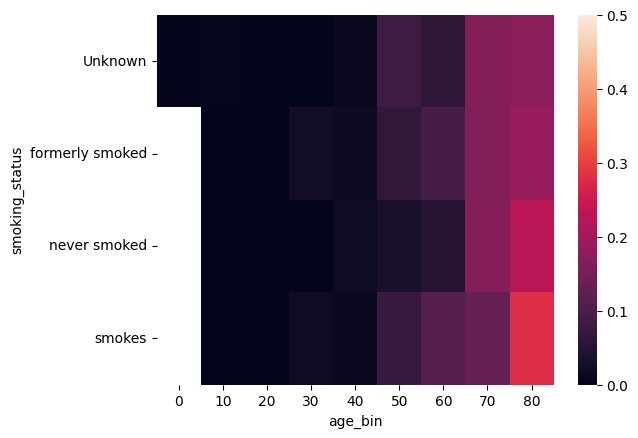

In [482]:
sns.heatmap(
    df.pivot_table(
        values="stroke",
        index="smoking_status",
        columns="age_bin",
        aggfunc="mean"
    ),
    vmax=0.5
)

We can see that smoking significantly increases chance of stroke (especially with rising age).

Not smoking means lower probability of stroke in ages 40-60.

<Axes: xlabel='age', ylabel='bmi'>

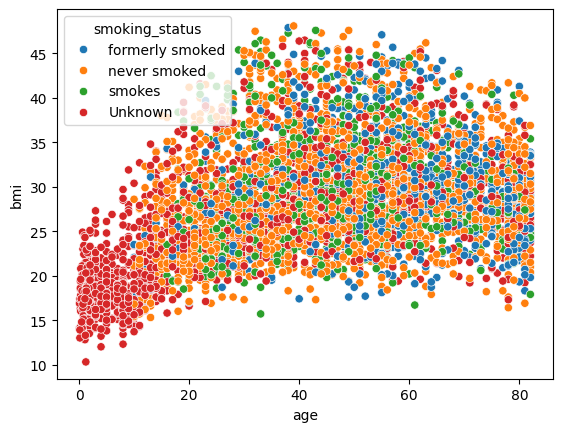

In [483]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="smoking_status",
    data=df
)

We can set smoking status of those under age of 15 to never smoked.

As for the rest, we can do a coin toss.

In [484]:
df.loc[df["age"]<=15]["smoking_status"].value_counts()

smoking_status
Unknown            614
never smoked        81
formerly smoked     19
smokes               3
Name: count, dtype: int64

In [485]:
df.loc[df["age"]>15]["smoking_status"].value_counts()

smoking_status
never smoked       1725
Unknown             872
formerly smoked     835
smokes              768
Name: count, dtype: int64

In [486]:
import random

for i in list(df.index):
    smoking_status = df.at[i, "smoking_status"]
    age = df.at[i, "age"]
    if smoking_status == "Unknown":
        if age<=15:
            df.at[i, "smoking_status"] = "never smoked"
        else:
            df.at[i, "smoking_status"] = random.choices(
        population=["never smoked", "formerly smoked", "smokes"], 
        weights=[0.52, 0.25, 0.23]
    )[0]

<Axes: xlabel='age', ylabel='bmi'>

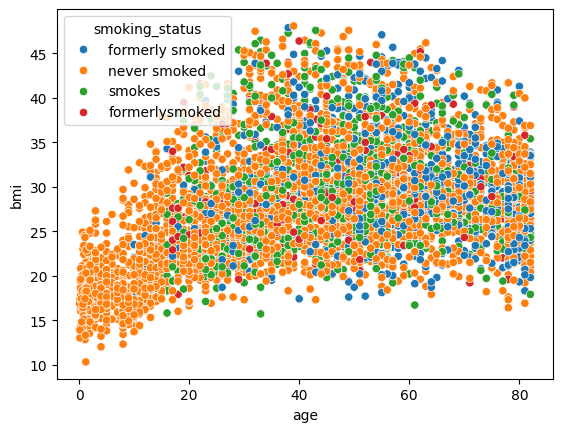

In [487]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="smoking_status",
    data=df
)